In [1]:
%run preamble.py

### Bear put option strategy on META

-- A bear put strategy involves buying a lower strike put while simutaneously selling a higher strike put.

In [2]:
ticker = 'META'
start = dt.datetime.today() - dt.timedelta(days = 31)
end = dt.datetime.today()
stock_data = yf.download(ticker,start = start - dt.timedelta(days = 100), end=end)
returns = stock_data.Close.pct_change().dropna()
trade_date = stock_data.index.values[68]
print(f'Trade begins on {trade_date}')

[*********************100%***********************]  1 of 1 completed
Trade begins on 2023-07-31T00:00:00.000000000


In [3]:
#GARCH volatility predictions accuracy vs 30-day rolling average

# Split Data into Training and Testing Sets
testing_set = returns.iloc[-21:]
training_set = returns.iloc[:-21]

#Calculate 30-Day Moving Average on the Testing Set
moving_average_30d_full = returns.rolling(window=21).std().dropna()
moving_average_30d = moving_average_30d_full[-21:] #95% volatility cofidence

# Step 4: Perform GARCH Modeling on the Training Set
# Rescale the data (multiply by 100)
training_set_scaled = training_set * 100

# Fit the GARCH(1,1) model to the rescaled training set
garch_model = arch_model(training_set_scaled, vol='Garch', p=1, q=1)
results = garch_model.fit(disp='off')

# Step 5: Calculate GARCH volatility for the testing set
garch_volatility_rescaled = results.conditional_volatility[-21:]/(100)

mse_GARCH = np.mean((np.array(garch_volatility_rescaled.values) - np.array(moving_average_30d.values))**2)


average_moving_average = np.mean(np.array(moving_average_30d.values))
mse_ma = np.mean((np.array(moving_average_30d.values) - average_moving_average)**2)

print(f'The mse of GARCH volatility predicitions: {mse_GARCH}')
print(f"The mse of rolling average volatilitiy predictions: {mse_ma}")

The mse of GARCH volatility predicitions: 1.4338966438503561e-05
The mse of rolling average volatilitiy predictions: 2.884771441116141e-06


In [4]:
forecast = results.forecast(horizon = 21, reindex = True)
sigma_GARCH = np.sqrt(forecast.variance.iloc[-1][-1])*np.sqrt(252)/100
sigma_rolling = average_moving_average * np.sqrt(252)
sigma_GARCH, sigma_rolling

(0.29286055587965537, 0.3467610276764249)

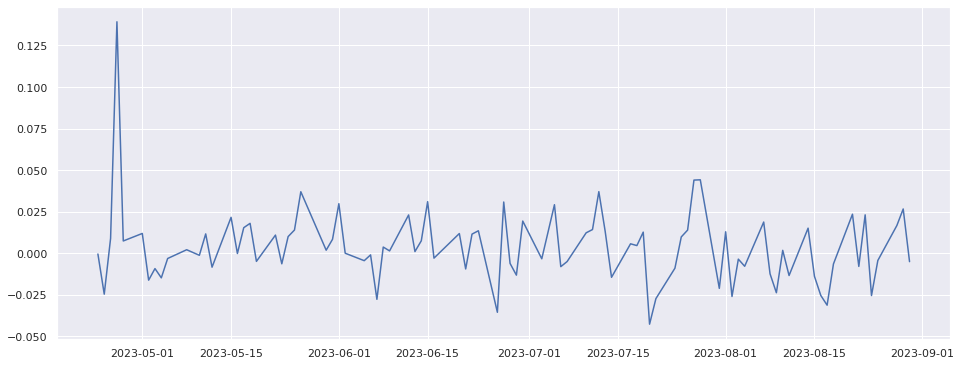

The rolling average is large because of a market fluctuation       that took place at the beginning of the testing period. We therefore elect to use GARCH.       To confirm our choice, we repeat our analysis of volatility measurements using a smaller training window that avoids the large market fluctuation.


In [5]:
plt.plot(returns)
plt.show()
print('The rolling average is large because of a market fluctuation \
      that took place at the beginning of the testing period. We therefore elect to use GARCH. \
      To confirm our choice, we repeat our analysis of volatility measurements using a smaller training window that avoids the large market fluctuation.' )

In [6]:
#GARCH volatility predictions accuracy vs 30-day rolling average

# Split Data into Training and Testing Sets
testing_set = returns.iloc[-15:]
training_set = returns.iloc[:-15]

#Calculate 30-Day Moving Average on the Testing Set
moving_average_30d_full = returns.rolling(window=15).std().dropna()
moving_average_30d = moving_average_30d_full[-15:] #95% volatility cofidence

# Step 4: Perform GARCH Modeling on the Training Set
# Rescale the data (multiply by 100)
training_set_scaled = training_set * 100

# Fit the GARCH(1,1) model to the rescaled training set
garch_model = arch_model(training_set_scaled, vol='Garch', p=1, q=1)
results = garch_model.fit(disp='off')

# Step 5: Calculate GARCH volatility for the testing set
garch_volatility_rescaled = results.conditional_volatility[-15:]/(100)

mse_GARCH = np.mean((np.array(garch_volatility_rescaled.values) - np.array(moving_average_30d.values))**2)


average_moving_average = np.mean(np.array(moving_average_30d.values))
mse_ma = np.mean((np.array(moving_average_30d.values) - average_moving_average)**2)

print(f'The mse of GARCH volatility predicitions: {mse_GARCH}')
print(f"The mse of rolling average volatilitiy predictions: {mse_ma}")

The mse of GARCH volatility predicitions: 6.72740222583721e-06
The mse of rolling average volatilitiy predictions: 5.77608178732261e-06


In [7]:
forecast = results.forecast(horizon = 21, reindex = True)
sigma_GARCH = np.sqrt(forecast.variance.iloc[-1][-1])*np.sqrt(252)/100
sigma_rolling = average_moving_average * np.sqrt(252)
print(f"Predicted GARCH volatility {sigma_GARCH}")
print(f"Predicted rolling volatility {sigma_rolling}")
print('Predicted volatilities are much closer with the smaller trading window. We split the difference and model the stock movement as a Geometric \
Brownian motion with an annual volatility of .3')
sigma = .3

Predicted GARCH volatility 0.2962294841083289
Predicted rolling volatility 0.31178385680705145
Predicted volatilities are much closer with the smaller trading window. We split the difference and model the stock movement as a Geometric Brownian motion with an annual volatility of .3


Found the following option choices on META available on a trading platform with a common expiration date of August 28.

## Put option

-Price = 8.59

-Strike = 320

## Call option

-Price = 8.20

-Strike = 330

In [8]:
S0 = stock_data.loc[trade_date].Open
K0 = 320
K1 = 330
T = 21/252
iv_put = iv(10.25, S0, K0, T, 0, 'p')
iv_call = iv(17.50, S0, K1, T, 0, 'p')
print(f"Implied volatility of put contract: {iv_put}")
print(f"Implied volatility of call contract: {iv_call}")
print('We explore the choice of selling the contract with a higher implied volatility while simutaneously purchasing the contract with \
a smaller implied volatility.')

Implied volatility of put contract: 0.3240065459865562
Implied volatility of call contract: 0.37535028945282145
We explore the choice of selling the contract with a higher implied volatility while simutaneously purchasing the contract with a smaller implied volatility.


In [9]:
delta_put = delta('p', S0, K0, T, 0, sigma)
delta_call = delta('p', S0, K1, T, 0, sigma)
delta_put, delta_call

print(f"Delta of put contract {delta_put}")
print(f"Delta of call contract {delta_call}")
print('----------------------------------')
print("Purchasing one contract and sell and selling the other will produce a near delta neutral position")

Delta of put contract -0.4302683872518891
Delta of call contract -0.5712783154826596
----------------------------------
Purchasing one contract and sell and selling the other will produce a near delta neutral position


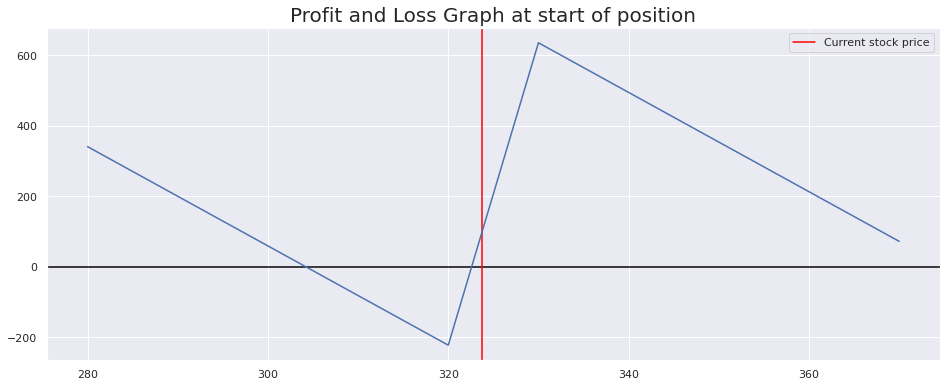

In [10]:
#Graph of profit and loss graph at start of position
stock_prices = np.linspace(280,370,100)
option0 = np.maximum(-stock_prices+K0,0)
option1 = np.maximum(-stock_prices+K1,0)
position_delta = 100*(delta('p', S0, K0, T, 0, sigma)-delta('p', S0, K1, T, 0, sigma))
position = 100*option0 - 100*option1 - position_delta*(stock_prices-S0) - 100*10.25 + 100*17.50
plt.axhline(y=0, color='black')
plt.axvline(x = S0, color = 'red', label = 'Current stock price')
plt.plot(stock_prices, position)
plt.title('Profit and Loss Graph at start of position', size = 20)
plt.legend()
plt.show()


In [15]:
#Monte Carlo simulation of expected profit 07/31/2023
S0 = stock_data.loc[trade_date].Open
T = 21/252
steps = 21
DT = T / steps
TTE = [T - DT * i for i in range(0, steps + 1)]
r = 0
N = 1000000
K0 = 320
K1 = 330

stock_paths = geo_paths(S0, T, sigma, steps, N)
avg_stock_values = [np.mean(stock_paths[i]) for i in range(len(stock_paths))]
put_bought_values = np.maximum(-stock_paths[-1]+K0, 0)
call_bought_values = np.maximum(-stock_paths[-1] + K1, 0)

put_bought = 100
call_bought = -100
put_bought_premium = 10.25
call_bought_premium = 17.50


deltas_put = [MC_delta(avg_stock_values[i], TTE[i], sigma, 10000, K0, 1, 0) for i in range(len(stock_paths))]
put_deltas_bought = [deltas_put[i]['delta_put'] for i in range(len(stock_paths))]

deltas_call = [MC_delta(avg_stock_values[i], TTE[i], sigma, 10000, K1, 1, 0) for i in range(len(stock_paths))]
call_deltas_bought = [deltas_call[i]['delta_put'] for i in range(len(stock_paths))]

X_put_bought = [-put_deltas_bought[i] * ((stock_paths[i + 1] - stock_paths[i])) for i in range(steps)]
X_call_bought = [-call_deltas_bought[i] * ((stock_paths[i + 1] - stock_paths[i])) for i in range(steps)]

put_hedge_bought = np.sum(X_put_bought, axis=0)
call_hedge_bought = np.sum(X_call_bought, axis=0)

hedge_put_bought_values = put_bought_values + put_hedge_bought
hedge_call_bought_values = call_bought_values + call_hedge_bought

position_values = (put_bought*hedge_put_bought_values+call_bought*hedge_call_bought_values)
expected_profit = np.mean(position_values) - put_bought*put_bought_premium - call_bought*call_bought_premium
stand_err = standard_error(position_values, T)
profit_chance = per_in_money_paths(position_values- put_bought*put_bought_premium - call_bought*call_bought_premium)

amount_invested = -np.min(position)
roi = expected_profit/amount_invested

print(f'Amount Invested: {amount_invested}')
print(f'Expected profit 07/31/2023: {expected_profit}')
print(f'Standard Error 07/31/2023: {stand_err}')
print(f'Chance of profit 07/31/2023: {profit_chance*100}%')
print(f'Expected Return on Investment: {roi*100}%')



Amount Invested: 222.96730205659378
Expected profit 07/31/2023: 189.2628015334917
Standard Error 07/31/2023: 0.47490613476402777
Chance of profit 07/31/2023: 67.338%
Expected Return on Investment: 84.88365773267186%


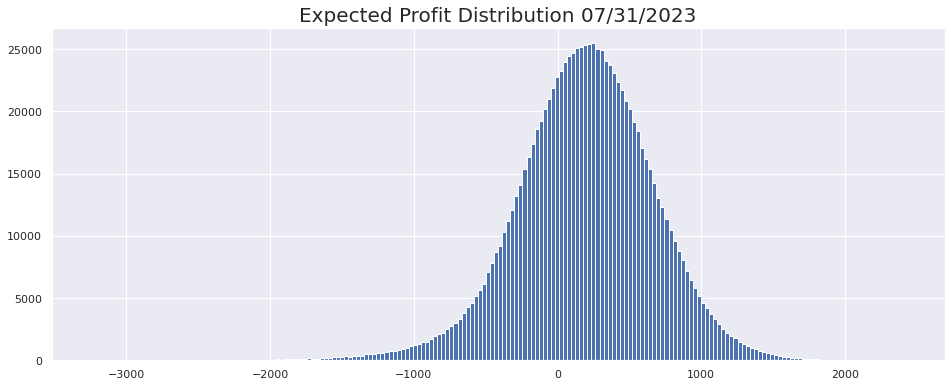

In [16]:
plt.hist(position_values -put_bought*put_bought_premium - call_bought*call_bought_premium, bins = 200)
plt.title('Expected Profit Distribution 07/31/2023', size = 20)
plt.show()

### The following code prints out the realized profit from the trade.

In [18]:
end_date = np.datetime64('2023-08-28T00:00:00.000000000')
stock_data_subset = stock_data[trade_date :]
stock_path = stock_data_subset.Open.loc[:end_date].values

S0 = stock_data.loc[trade_date].Open
T = 21/252
steps = 20
DT = T / steps
TTE = [T - DT * i for i in range(0, steps + 1)]
r = 0
N = 1000000
K0 = 320
K1 = 330

put_bought_values = np.maximum(-stock_path[-1]+K0, 0)
call_bought_values = np.maximum(-stock_path[-1] + K1, 0)


put_bought = 100
call_bought = -100
put_bought_premium = 10.25
call_bought_premium = 17.50

put_deltas_bought = [delta('p', stock_path[i], K0, TTE[i], 0 , sigma) for i in range(len(stock_path))]

call_deltas_bought = [delta('p', stock_path[i], K1, TTE[i], 0 , sigma) for i in range(len(stock_path))]

X_put_bought = [-put_deltas_bought[i] * ((stock_path[i + 1] - stock_path[i])) for i in range(steps)]
X_call_bought = [-call_deltas_bought[i] * ((stock_path[i + 1] - stock_path[i])) for i in range(steps)]

put_hedge_bought = np.sum(X_put_bought, axis=0)
call_hedge_bought = np.sum(X_call_bought, axis=0)

hedge_put_bought_values = put_bought_values + put_hedge_bought
hedge_call_bought_values = call_bought_values + call_hedge_bought

position_value = (put_bought*hedge_put_bought_values+call_bought*hedge_call_bought_values +100*(call_bought_premium - put_bought_premium))

print(f"Profit from bear call position: {round(position_value,2)}$")



Profit from bear call position: 195.0$


**Fees and Interest Rates**

Stock/ETF fees 
1) 0.000008*(Total dollar Trade Amount) (Min 0.01) SEC
2) 0.000145 * (Total Trade Volume) (Min 0.01 per stock) - (Max 7.27 per stock) FINRA

Option Fees
1) 0.000008*(Total Trade Amount) (Min \$0.01) SEC Sells only
2) 0.00244 *( No. of Contracts) (Min \$0.01) FINRA Sells only
3) 0.03005 * (No. of Contracts) Option Exchange Buys and Sells
4) 0.02 * (No. of Contracts) (Max $55 per Trade) OCC Buys and Sells

Borrowing Stock Fees:
1) $8$% annual interest

**Brokerage capital requirement**

1) initial = Net Premium + (Strike Price Long Call – Strike Price Short Call) x Contracts 

2) Maintance = (Strike Price Long Call – Strike Price Short Call) x Contracts 

